# Sparse AutoEncoder (SAE)

Sparse autoencoders use regualrization, which allows only a portion of neurons to be active at the same time. 

### Step 1 - Import libraries

In [1]:
# Tensorflow / Keras
from tensorflow import keras # for building Neural Networks
print('Tensorflow/Keras: %s' % keras.__version__) # print version
from keras import Input # for instantiating a keras tensor
from keras.layers import Dense # for adding Dense layers to AE model
from keras.models import Model # for creating a Neural Network Autoencoder model


# Data manipulation
import numpy as np # for data manipulation
print('numpy: %s' % np.__version__) # print version


# Visualization
import matplotlib 
import matplotlib.pyplot as plt # for plotting model loss
print('matplotlib: %s' % matplotlib.__version__) # print version
import seaborn as sns # for plotting neuron heatmap
print('seaborn: %s' % sns.__version__) # print version


# Other utilities
import sys
import os

# Assign main directory to a variable
main_dir=os.path.dirname(sys.path[0])
#print(main_dir)

Tensorflow/Keras: 2.7.0
numpy: 1.21.4
matplotlib: 3.5.1
seaborn: 0.11.2


### Step 2 - Load MNIST digit data

Shape of X_train:  (60000, 28, 28)
Shape of y_train:  (60000,)
Shape of X_test:  (10000, 28, 28)
Shape of y_test:  (10000,)


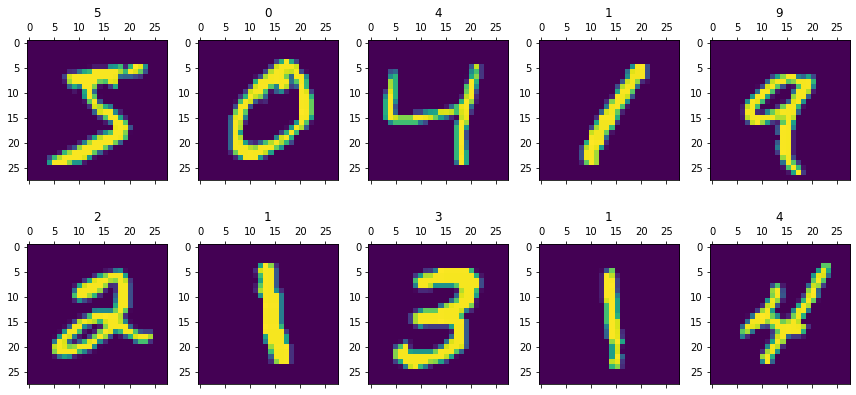

In [2]:
# Load digits data 
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

# Print shapes
print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_test: ", y_test.shape)

# Display images of the first 10 digits in the training set and their true lables
fig, axs = plt.subplots(2, 5, sharey=False, tight_layout=True, figsize=(12,6), facecolor='white')
n=0
for i in range(0,2):
    for j in range(0,5):
        axs[i,j].matshow(X_train[n])
        axs[i,j].set(title=y_train[n])
        n=n+1
plt.show() 

In [3]:
# Reshape and normalize (divide by 255) input data
X_train = X_train.reshape(60000, 784).astype("float32") / 255
X_test = X_test.reshape(10000, 784).astype("float32") / 255

# Print shapes
print("New shape of X_train: ", X_train.shape)
print("New shape of X_test: ", X_test.shape)

New shape of X_train:  (60000, 784)
New shape of X_test:  (10000, 784)


### Step 3 - Build two models: Autoencoder and Sparse Autoencoder model

##### Autoencoder

2022-04-24 17:52:59.055917: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "Autoencoder-Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 AE-Input-Layer (InputLayer)  [(None, 784)]            0         
                                                                 
 AE-Encoder-Hidden-Layer (De  (None, 16)               12560     
 nse)                                                            
                                                                 
 AE-Bottleneck-Layer (Dense)  (None, 16)               272       
                                                                 
 AE-Decoder-Hidden-Layer (De  (None, 16)               272       
 nse)                                                            
                                                                 
 AE-Output-Layer (Dense)     (None, 784)               13328     
                                                                 
Total params: 26,432
Trainable params: 26,432
Non

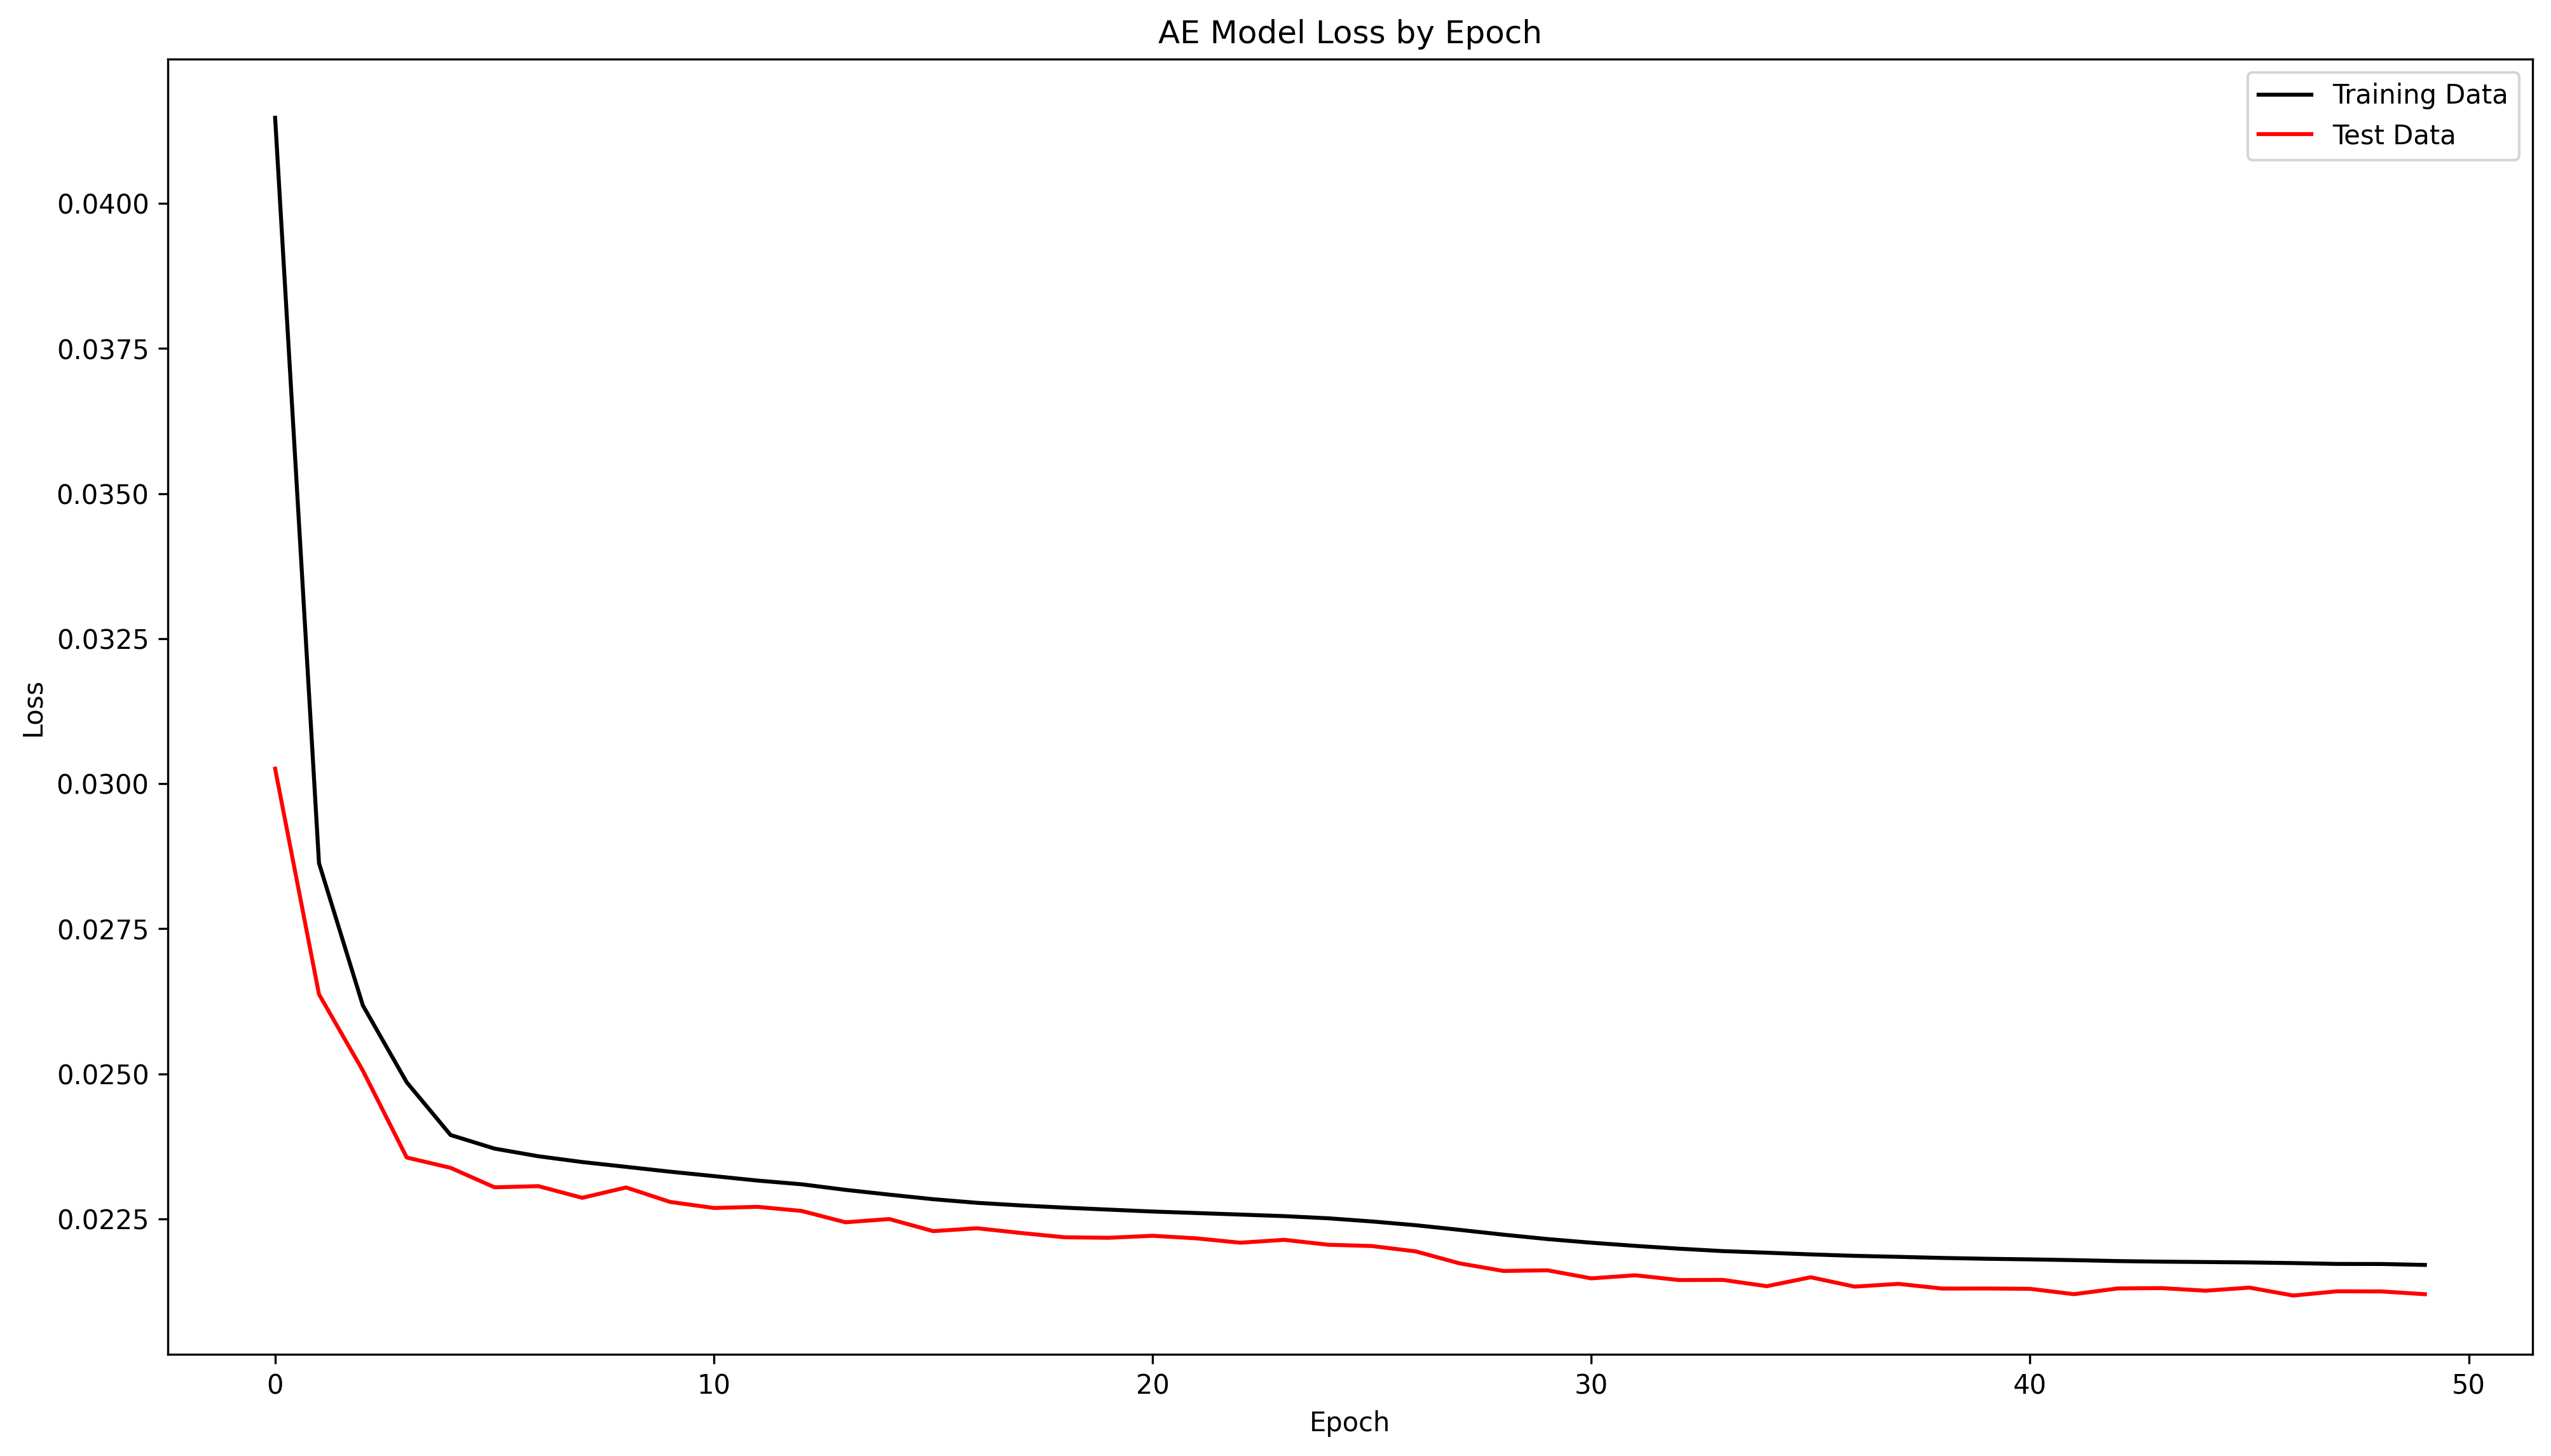

In [4]:
#----------- Build AE Model ----------#

# Shapes
AE_n_inputs=X_train.shape[1] #--- No. of neurons for the input and output layers
AE_n_hidden=16 #--- No. of neurons for the hidden layers (including bottleneck)

# Layers
AE_visible = Input(shape=(AE_n_inputs,), name='AE-Input-Layer') #--- Input-Layer 
AE_enc_hidden = Dense(units=AE_n_hidden, activation='relu', name='AE-Encoder-Hidden-Layer')(AE_visible) #--- Encoder-Hidden-Layer 
AE_bottleneck = Dense(units=AE_n_hidden, activation='relu', name='AE-Bottleneck-Layer')(AE_enc_hidden) #--- Bottleneck-Layer
AE_dec_hidden = Dense(units=AE_n_hidden, activation='relu', name='AE-Decoder-Hidden-Layer')(AE_bottleneck) #--- Decoder-Hidden-Layer 
AE_output = Dense(units=AE_n_inputs, activation='sigmoid', name='AE-Output-Layer')(AE_dec_hidden) #--- Output-Layer

# Define autoencoder model
AE_model = Model(inputs=AE_visible, outputs=AE_output, name='Autoencoder-Model')

# Compile autoencoder model
AE_model.compile(optimizer='adam', loss='mse')

# Print model summary
print(AE_model.summary())


# Fit the autoencoder model to reconstruct input
AE_history = AE_model.fit(X_train, X_train, epochs=50, batch_size=16, verbose=1, validation_data=(X_test, X_test))


#---------- Plot a loss chart ----------#
fig, ax = plt.subplots(figsize=(16,9), dpi=300)
plt.title(label='AE Model Loss by Epoch', loc='center')
ax.plot(AE_history.history['loss'], label='Training Data', color='black')
ax.plot(AE_history.history['val_loss'], label='Test Data', color='red')
ax.set(xlabel='Epoch', ylabel='Loss')
plt.legend()
plt.show()


#----------- Save AE Encoder Model ----------#

# Define an encoder model without the decoder
AE_encoder = Model(inputs=AE_visible, outputs=AE_bottleneck)

# Compile encoder model
AE_encoder.compile(optimizer='adam', loss='mse')

# Save the encoder model to file
AE_encoder.save(main_dir+'/data/AE_encoder.h5')


##### Sparse Autoencoder

Model: "Sparse-Autoencoder-Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 SAE-Input-Layer (InputLayer  [(None, 784)]            0         
 )                                                               
                                                                 
 SAE-Encoder-Hidden-Layer (D  (None, 16)               12560     
 ense)                                                           
                                                                 
 SAE-Bottleneck-Layer (Dense  (None, 16)               272       
 )                                                               
                                                                 
 SAE-Decoder-Hidden-Layer (D  (None, 16)               272       
 ense)                                                           
                                                                 
 SAE-Output-Layer (Dense)    (None, 784)  

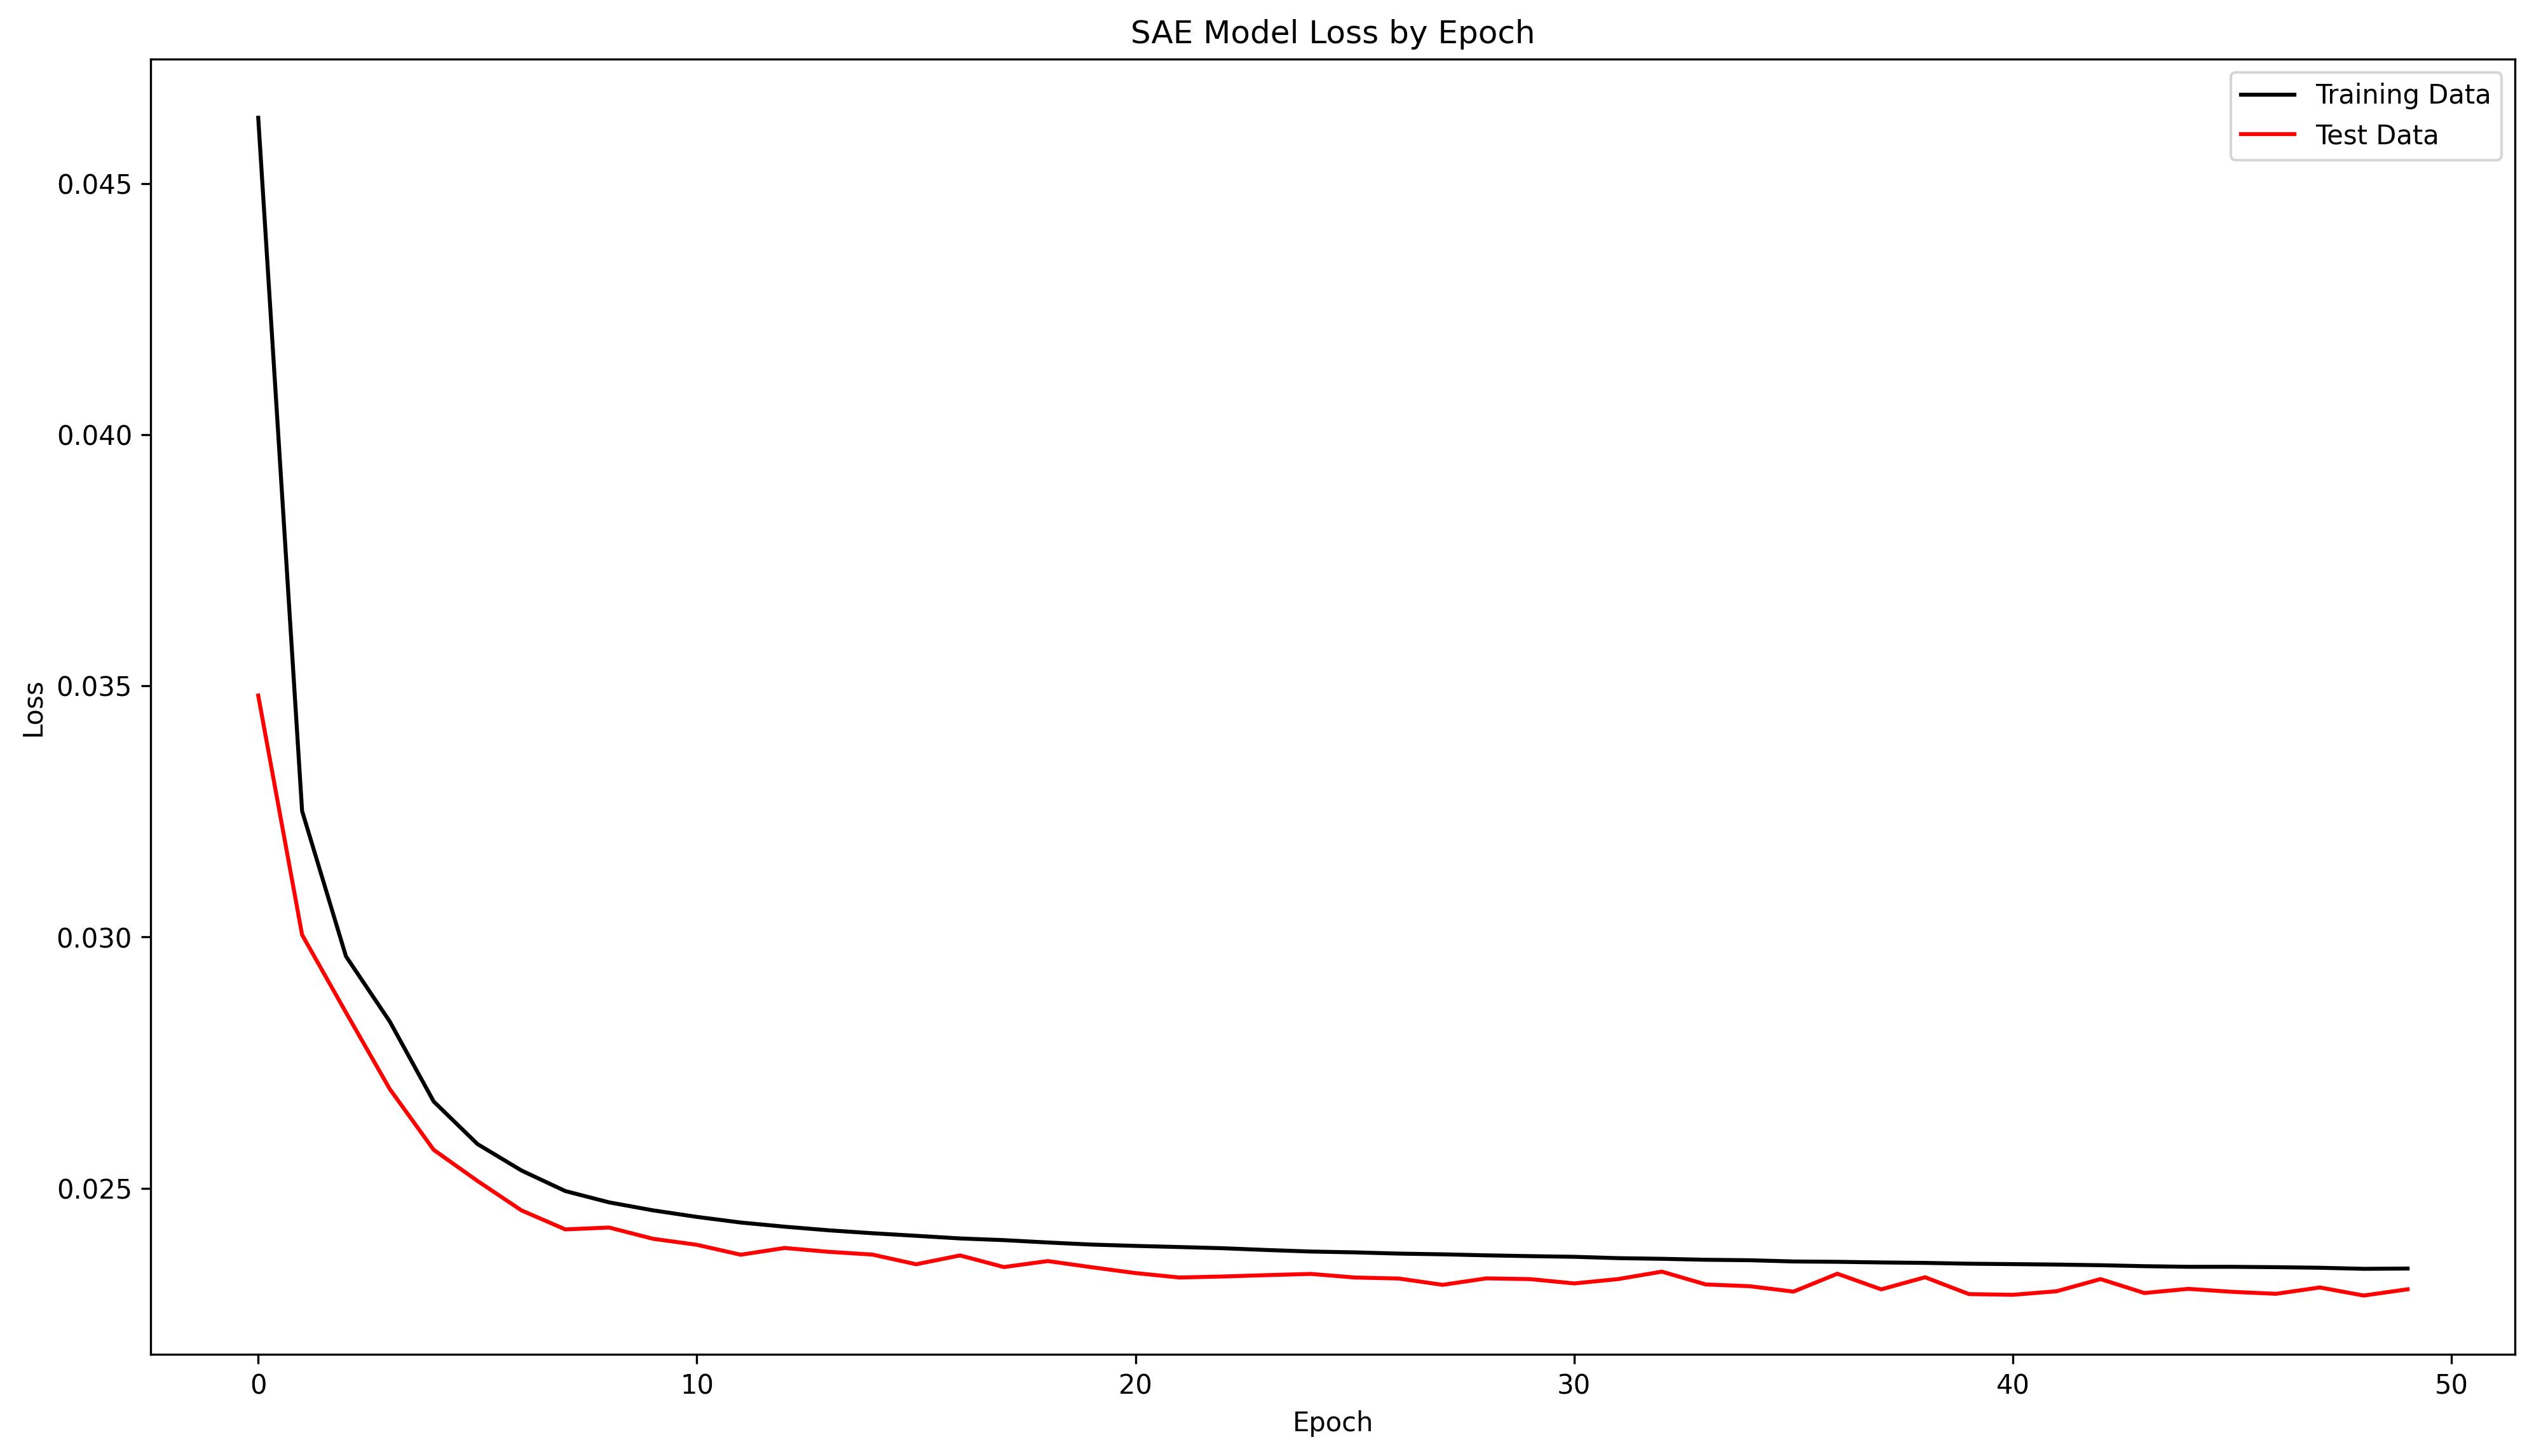

In [5]:
#----------- Build SAE Model ----------#

# Shapes
SAE_n_inputs=X_train.shape[1] #--- No. of neurons for the input and output layers
SAE_n_hidden=16 #--- No. of neurons for the hidden layers (including bottleneck)

# Layers
SAE_visible = Input(shape=(SAE_n_inputs,), name='SAE-Input-Layer') #--- Input-Layer 
SAE_enc_hidden = Dense(units=SAE_n_hidden, activation='relu', name='SAE-Encoder-Hidden-Layer')(SAE_visible) #--- Encoder-Hidden-Layer 
SAE_bottleneck = Dense(units=SAE_n_hidden, activation='relu', activity_regularizer=keras.regularizers.L1(0.0001), name='SAE-Bottleneck-Layer')(SAE_enc_hidden) #--- Bottleneck-Layer
SAE_dec_hidden = Dense(units=SAE_n_hidden, activation='relu', name='SAE-Decoder-Hidden-Layer')(SAE_bottleneck) #--- Decoder-Hidden-Layer 
SAE_output = Dense(units=SAE_n_inputs, activation='sigmoid', name='SAE-Output-Layer')(SAE_dec_hidden) #--- Output-Layer

# Define Sparse autoencoder model
SAE_model = Model(inputs=SAE_visible, outputs=SAE_output, name='Sparse-Autoencoder-Model')

# Compile Sparse autoencoder model
SAE_model.compile(optimizer='adam', loss='mse')

# Print model summary
print(SAE_model.summary())


# Fit the Sparse autoencoder model to reconstruct input
SAE_history = SAE_model.fit(X_train, X_train, epochs=50, batch_size=16, verbose=1, validation_data=(X_test, X_test))


#---------- Plot a loss chart ----------#
fig, ax = plt.subplots(figsize=(16,9), dpi=300)
plt.title(label='SAE Model Loss by Epoch', loc='center')
ax.plot(SAE_history.history['loss'], label='Training Data', color='black')
ax.plot(SAE_history.history['val_loss'], label='Test Data', color='red')
ax.set(xlabel='Epoch', ylabel='Loss')
plt.legend()
plt.show()


#----------- Save SAE Encoder Model ----------#

# Define an encoder model without the decoder
SAE_encoder = Model(inputs=SAE_visible, outputs=SAE_bottleneck)

# Compile encoder model
SAE_encoder.compile(optimizer='adam', loss='mse')

# Save the encoder model to file
SAE_encoder.save(main_dir+'/data/SAE_encoder.h5')


### Step 4 - Display images processed by AE and SAE models

##### Original images

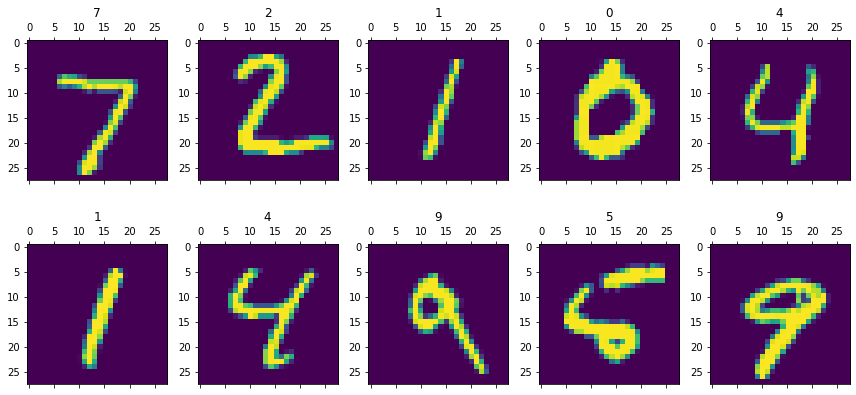

In [6]:
# Reshape back
X_test_back = X_test.reshape(10000, 28,28)

# Display first 10 test images
fig, axs = plt.subplots(2, 5, sharey=False, tight_layout=True, figsize=(12,6), facecolor='white')
n=0
for i in range(0,2):
    for j in range(0,5):
        axs[i,j].matshow(X_test_back[n])
        axs[i,j].set(title=y_test[n])
        n=n+1
plt.show() 

##### Images processed by AE

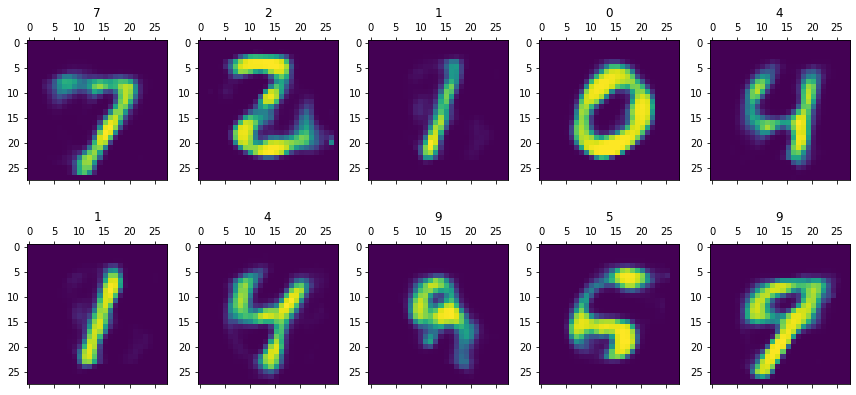

In [7]:
# Process images with Autoencoder
for i in range(0, 10):
    img=AE_model.predict(X_test[i].reshape(1,784))
    if i==0: 
        processed_imgs=np.copy(img) 
    else:
        processed_imgs=np.concatenate((processed_imgs, img))
processed_imgs=processed_imgs.reshape(10, 28, 28)

# Display processed images
fig, axs = plt.subplots(2, 5, sharey=False, tight_layout=True, figsize=(12,6), facecolor='white')
n=0
for i in range(0,2):
    for j in range(0,5):
        axs[i,j].matshow(processed_imgs[n])
        axs[i,j].set(title=y_test[n])
        n=n+1
plt.show() 

##### Images processed by SAE

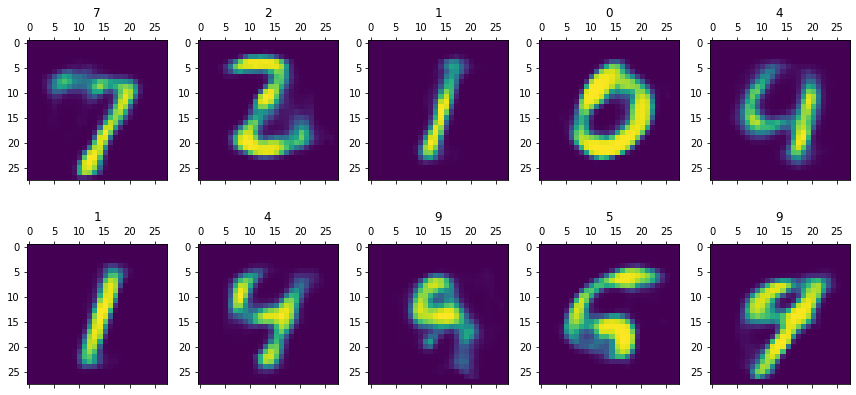

In [8]:
# Process images with Sparse-Autoencoder
for i in range(0, 10):
    img=SAE_model.predict(X_test[i].reshape(1,784))
    if i==0: 
        processed_imgs=np.copy(img) 
    else:
        processed_imgs=np.concatenate((processed_imgs, img))
processed_imgs=processed_imgs.reshape(10, 28, 28)

# Display processed images
fig, axs = plt.subplots(2, 5, sharey=False, tight_layout=True, figsize=(12,6), facecolor='white')
n=0
for i in range(0,2):
    for j in range(0,5):
        axs[i,j].matshow(processed_imgs[n])
        axs[i,j].set(title=y_test[n])
        n=n+1
plt.show() 

### Step 5 - Check neuron activations

##### Chosen images

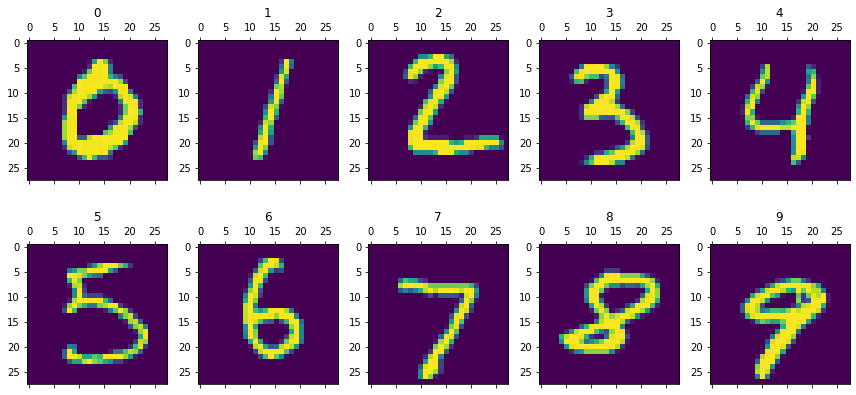

In [9]:
# Reshape back
#X_test_back = X_test.reshape(10000, 28, 28)

# Display select images of digits in the testing set and their true lables
fig, axs = plt.subplots(2, 5, sharey=False, tight_layout=True, figsize=(12,6), facecolor='white')
imglist=[3,2,1,32,4,15,21,0,61,9]
n=0
for i in range(0,2):
    for j in range(0,5):
        k=imglist[n]
        axs[i,j].matshow(X_test_back[k])
        axs[i,j].set(title=y_test[k])
        n=n+1
plt.show() 

##### Encode the same 10 digits with AE encoder and SAE encoder

In [10]:
imglist=[3,2,1,32,4,15,21,0,61,9]

# Encode images with AE encoder
for i in imglist:
    enc=AE_encoder.predict(X_test[i].reshape(1,784))
    if i==imglist[0]: 
        AE_encoded_imgs=np.copy(enc) 
    else:
        AE_encoded_imgs=np.concatenate((AE_encoded_imgs, enc))
#AE_encoded_imgs


# Encode images with SAE encoder
for i in imglist:
    enc=SAE_encoder.predict(X_test[i].reshape(1,784))
    if i==imglist[0]: 
        SAE_encoded_imgs=np.copy(enc) 
    else:
        SAE_encoded_imgs=np.concatenate((SAE_encoded_imgs, enc))
#SAE_encoded_imgs

##### Show neuron activation heatmap in the bottleneck for the two encoders

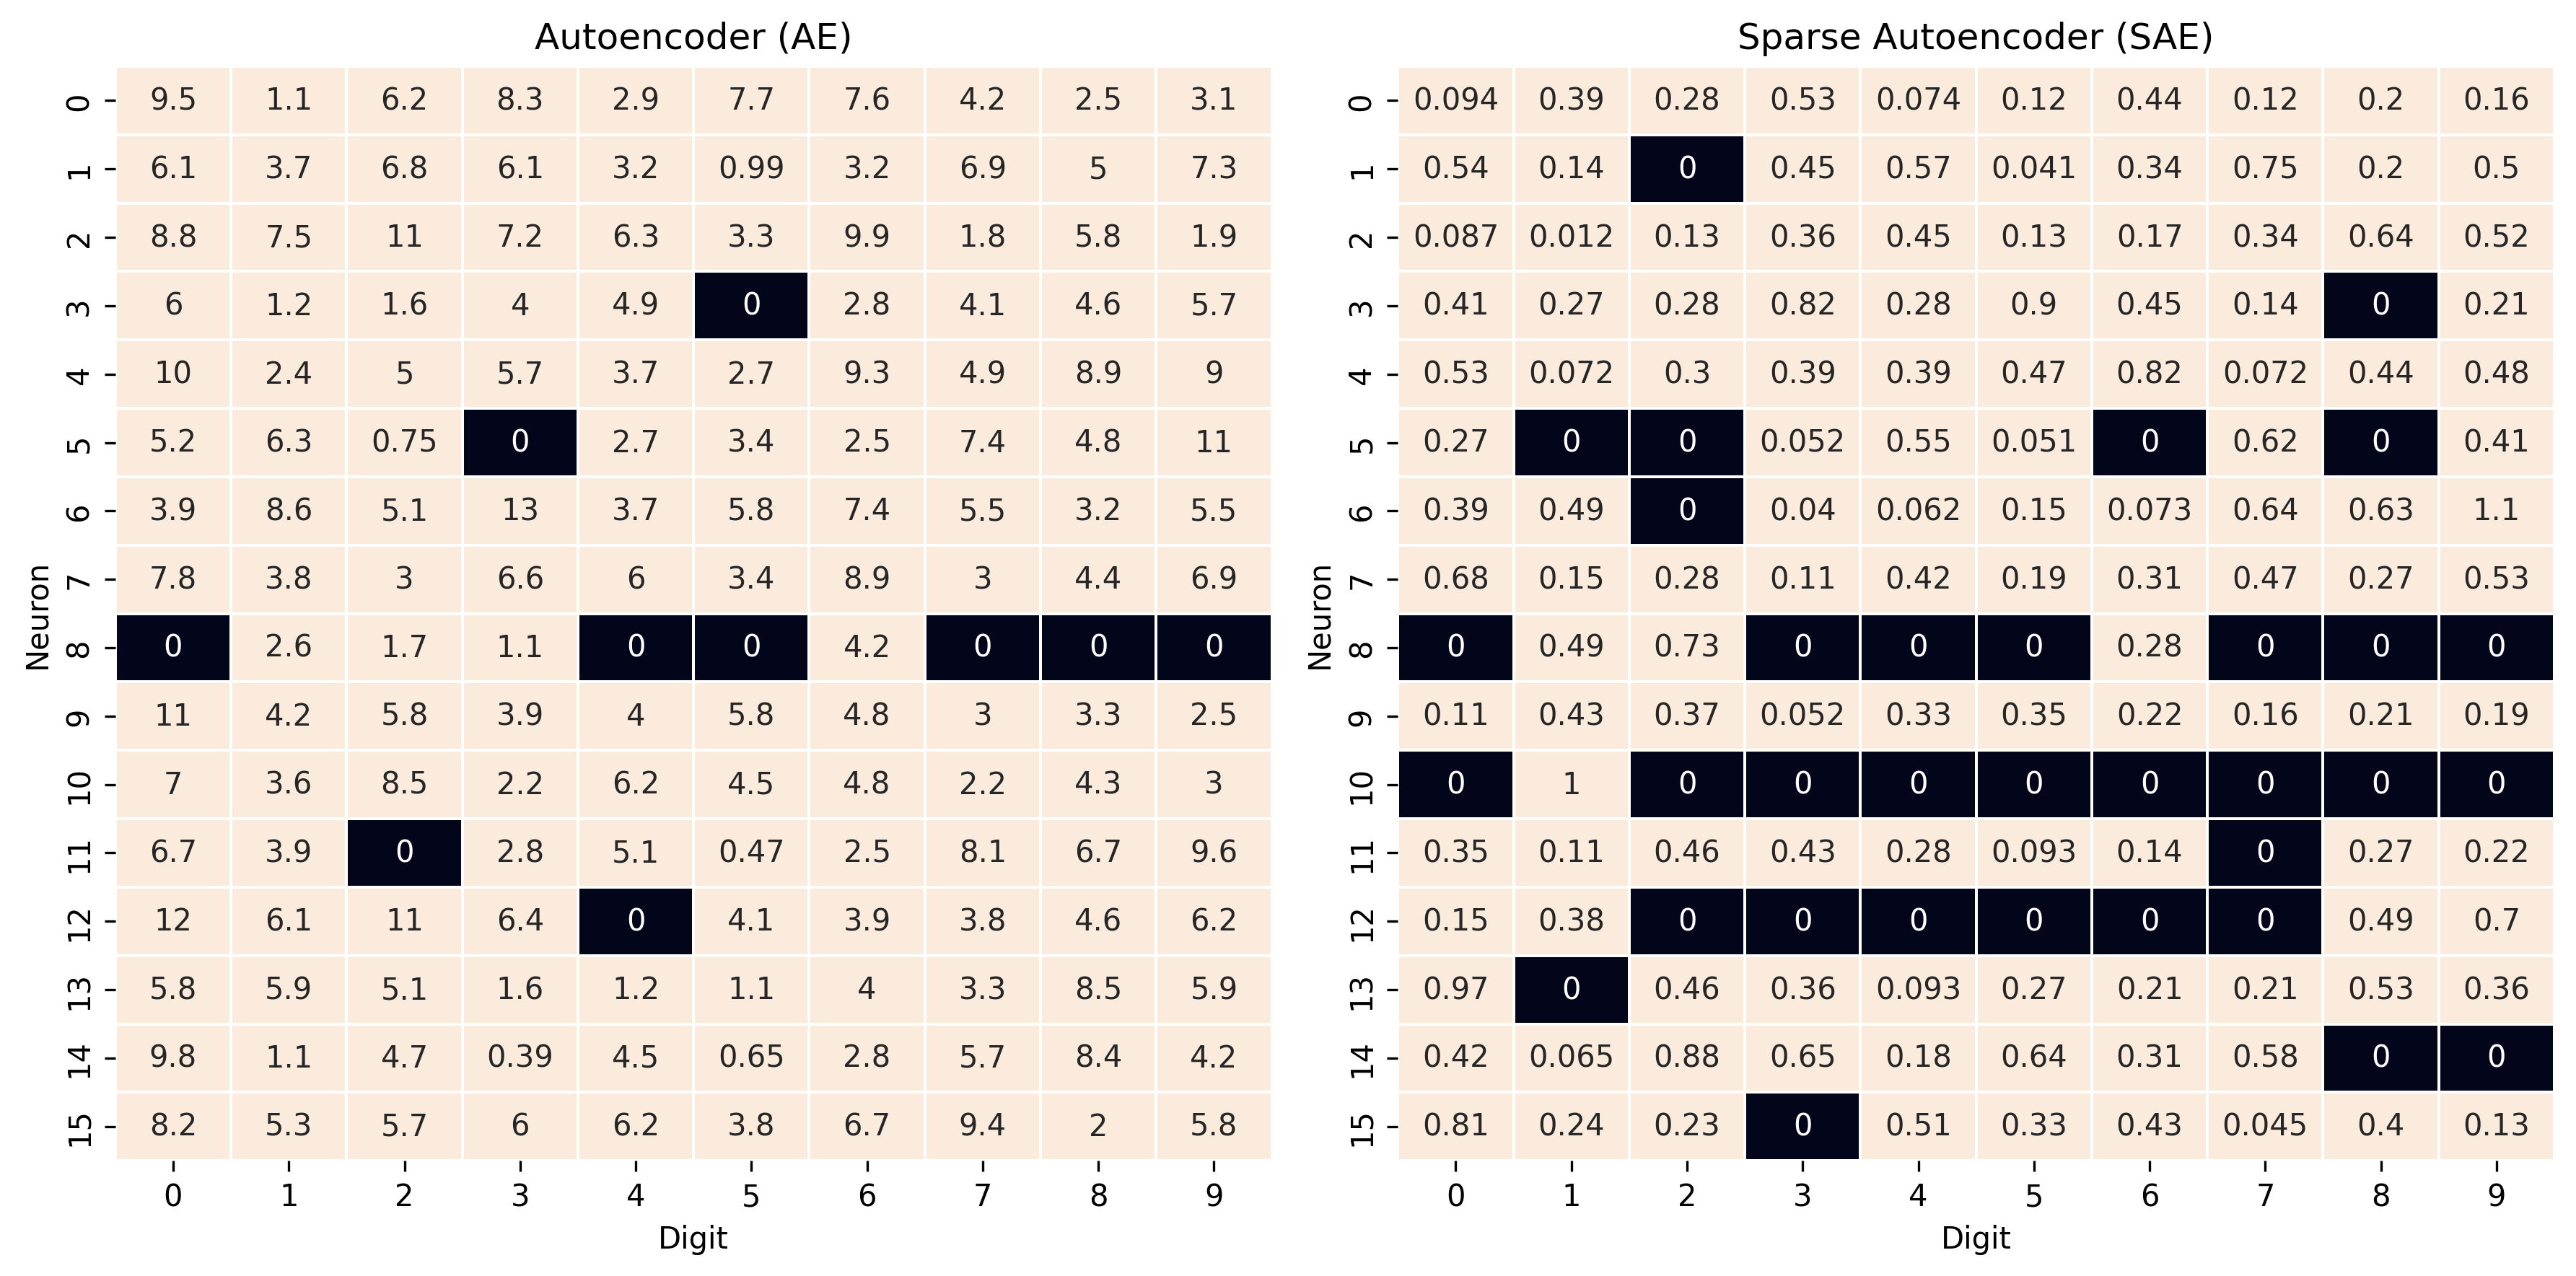

In [11]:
# Plot SNS heatmap
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, sharey=False, tight_layout=True, figsize=(12,6), dpi=300)
sns.heatmap(AE_encoded_imgs.transpose(), linewidth=0.5, annot=True, vmin=0, vmax=0.01, cbar=False, ax=ax1)
sns.heatmap(SAE_encoded_imgs.transpose(), linewidth=0.5, annot=True, vmin=0, vmax=0.00001, cbar=False, ax=ax2)
ax1.set(title='Autoencoder (AE)', xlabel='Digit', ylabel='Neuron')
ax2.set(title='Sparse Autoencoder (SAE)', xlabel='Digit', ylabel='Neuron')
plt.show()

 In the above example SAE is more than 3 times sparser

# End of Program